C:\Tools\Anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


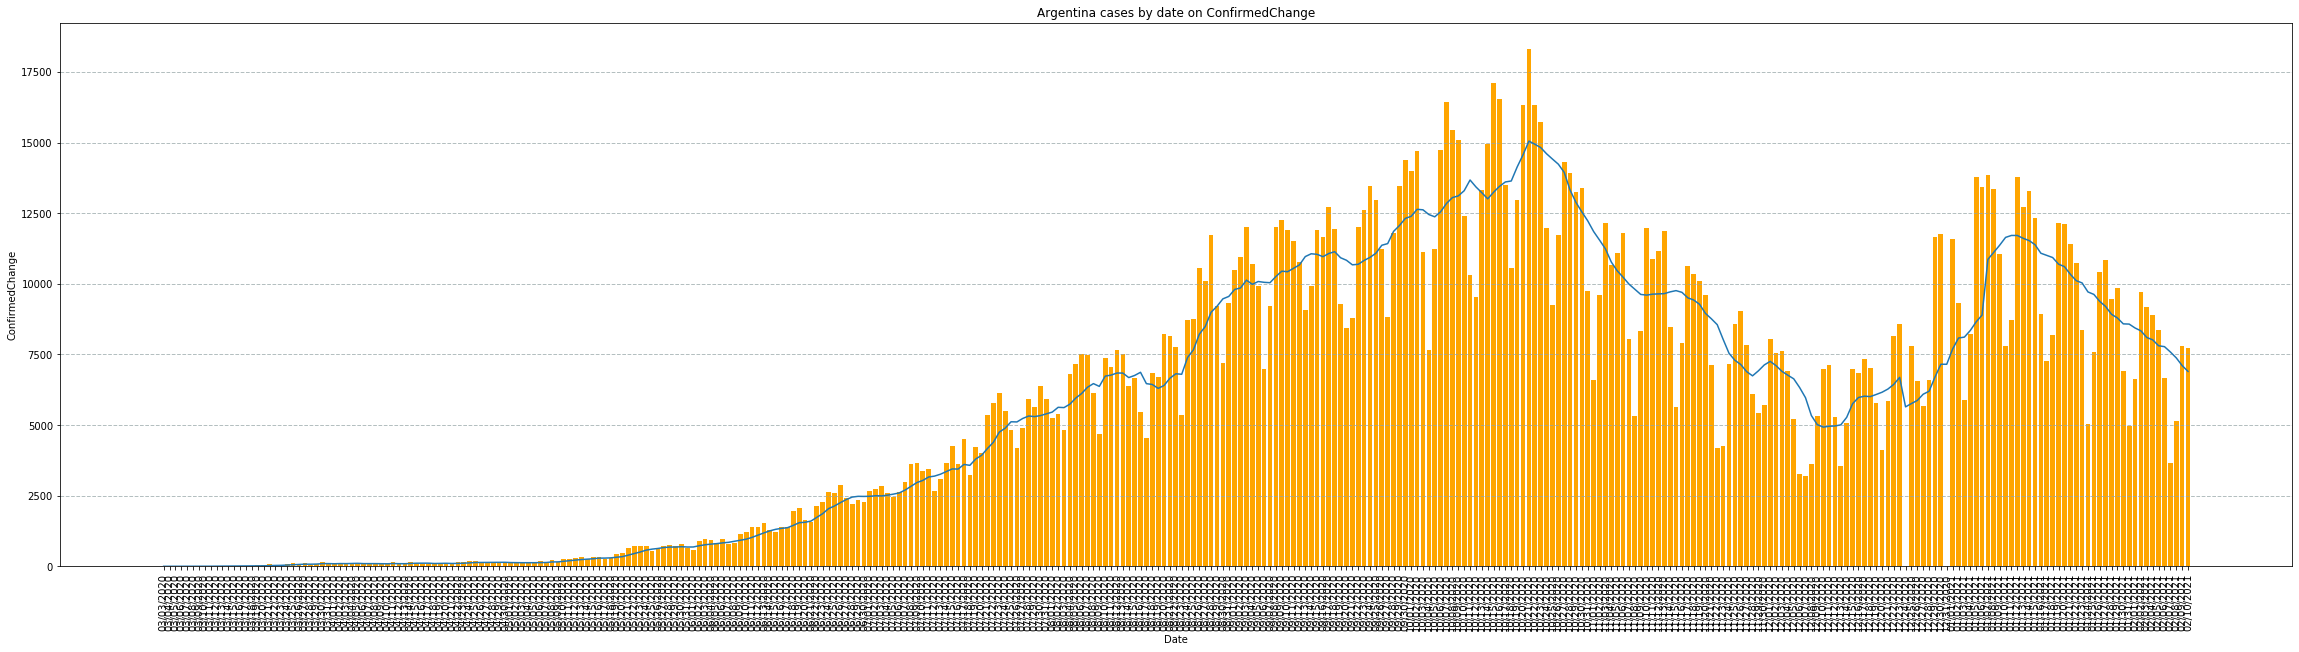

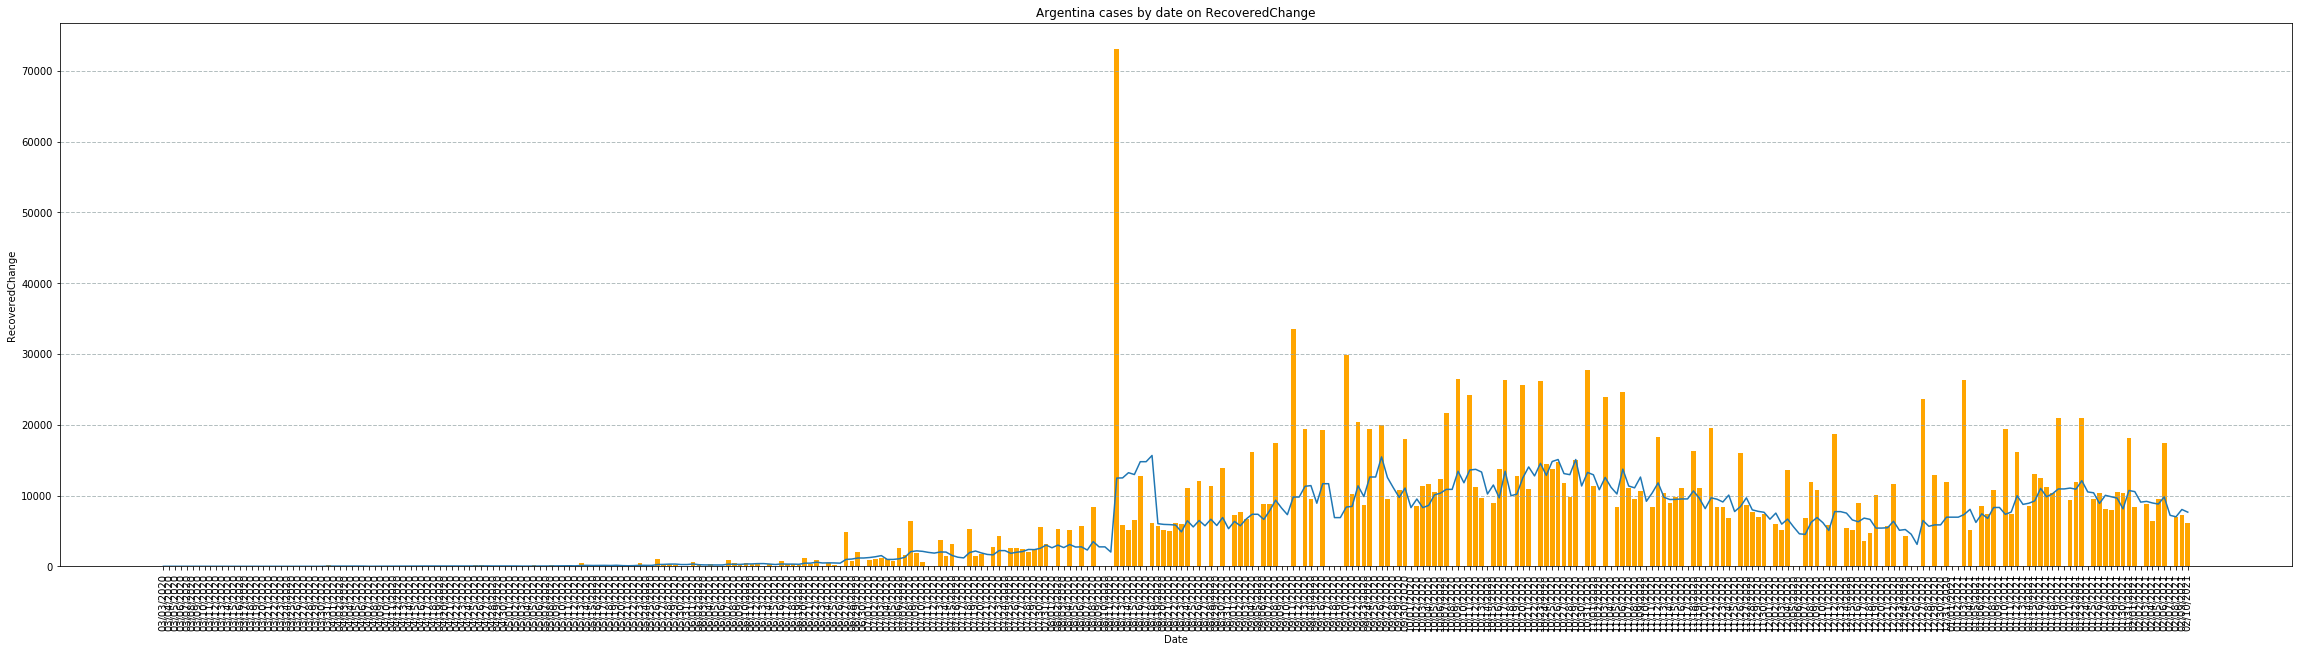

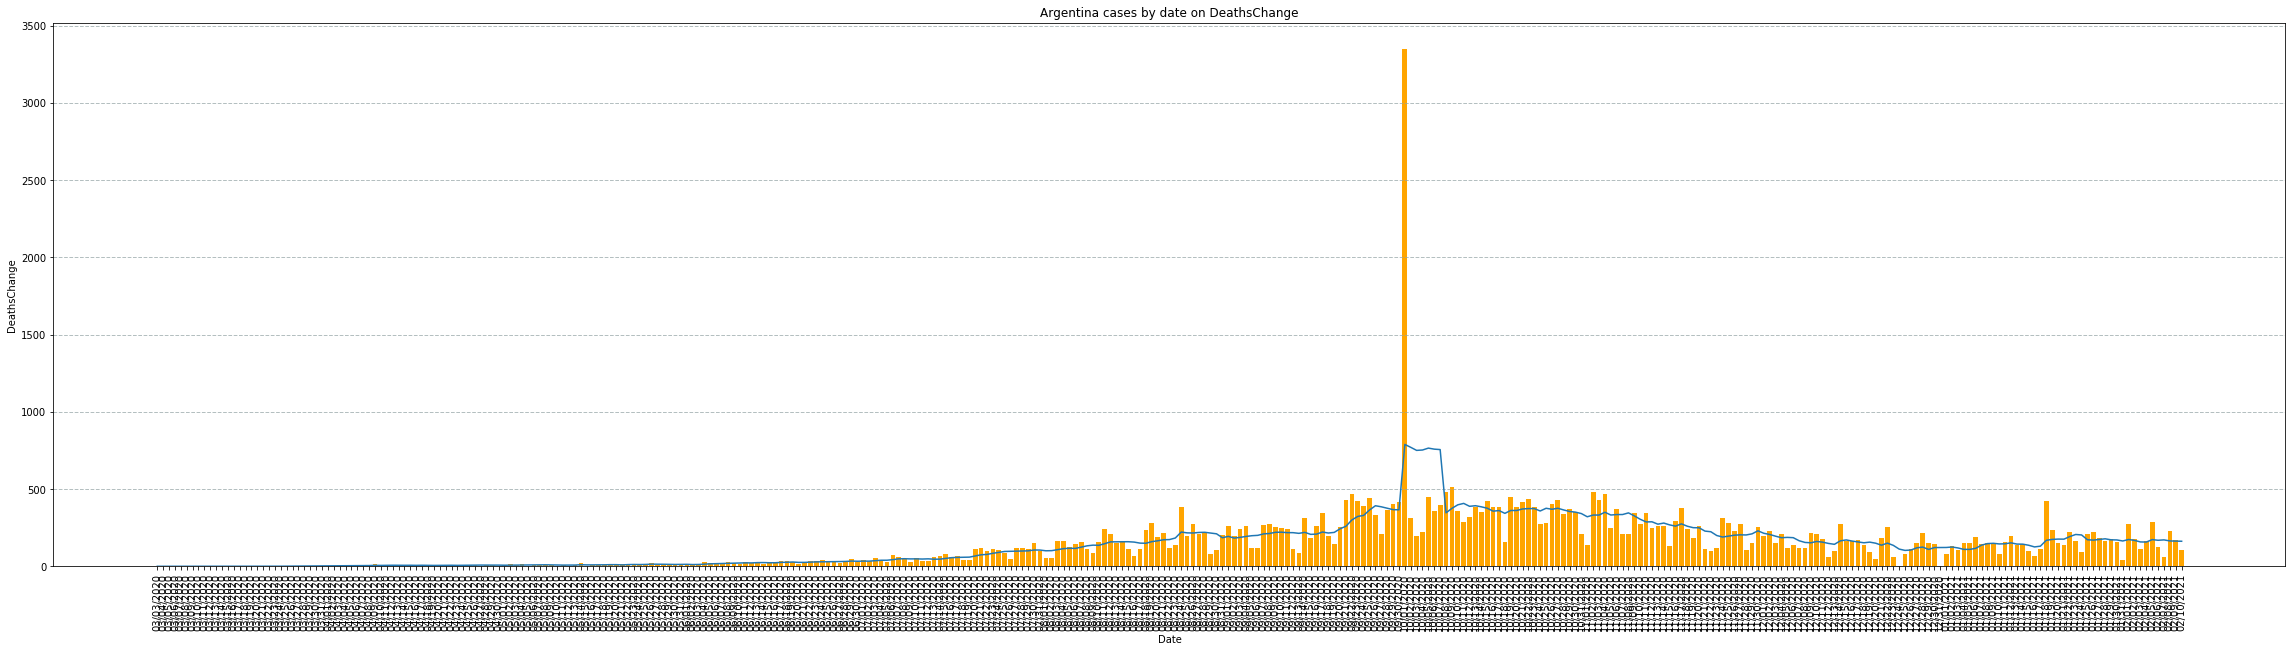

C:\Tools\Anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


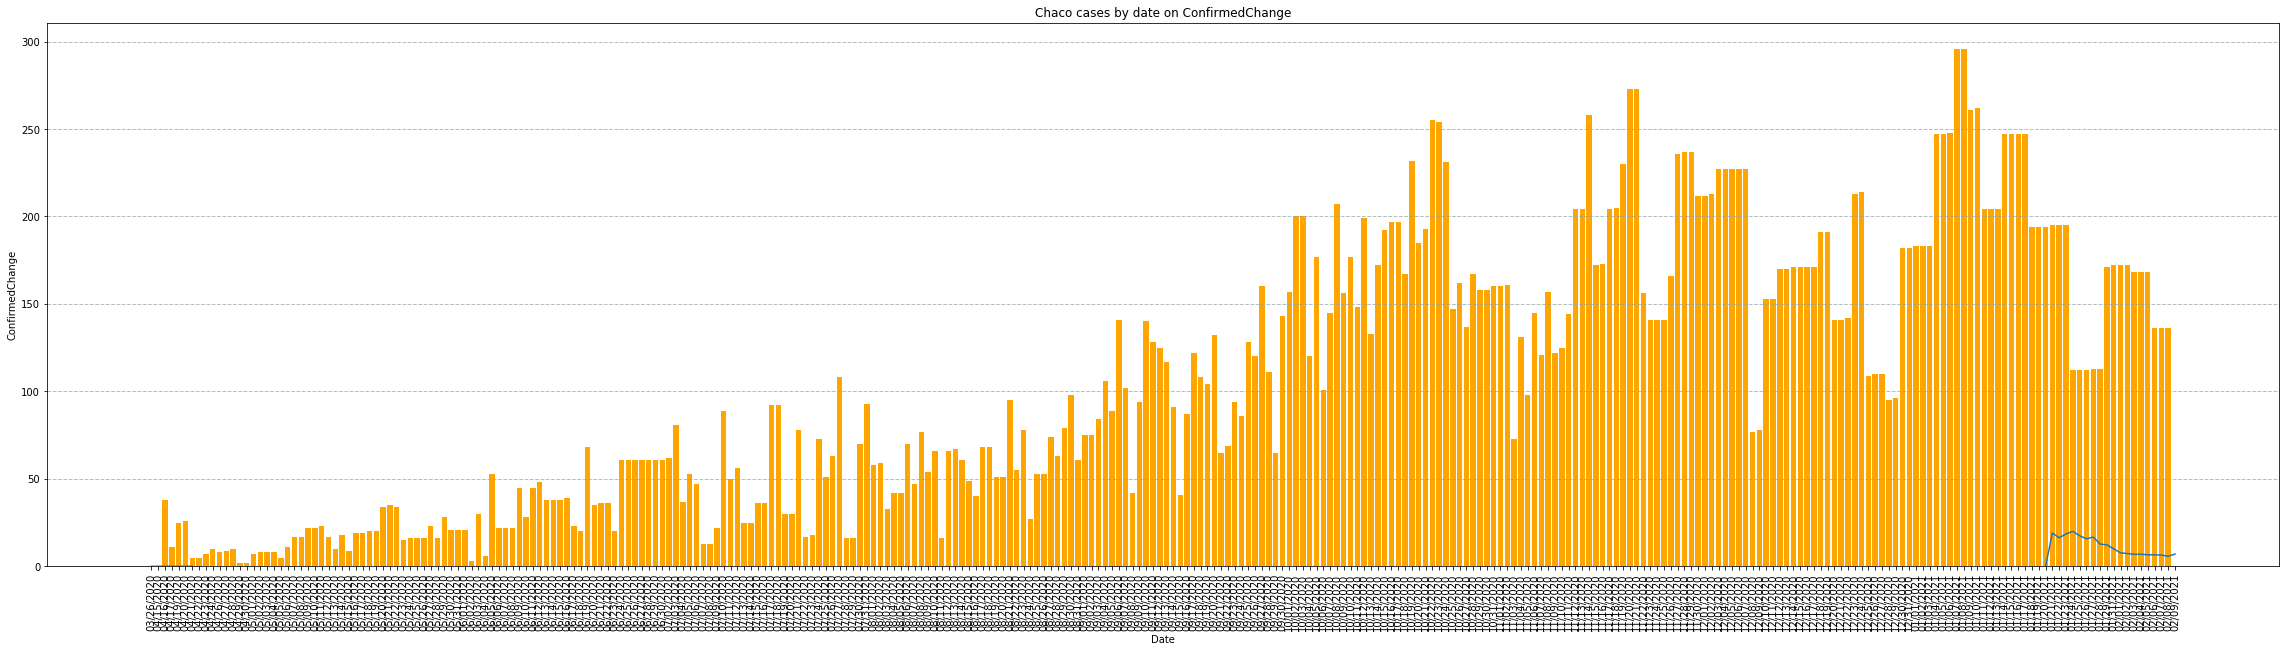

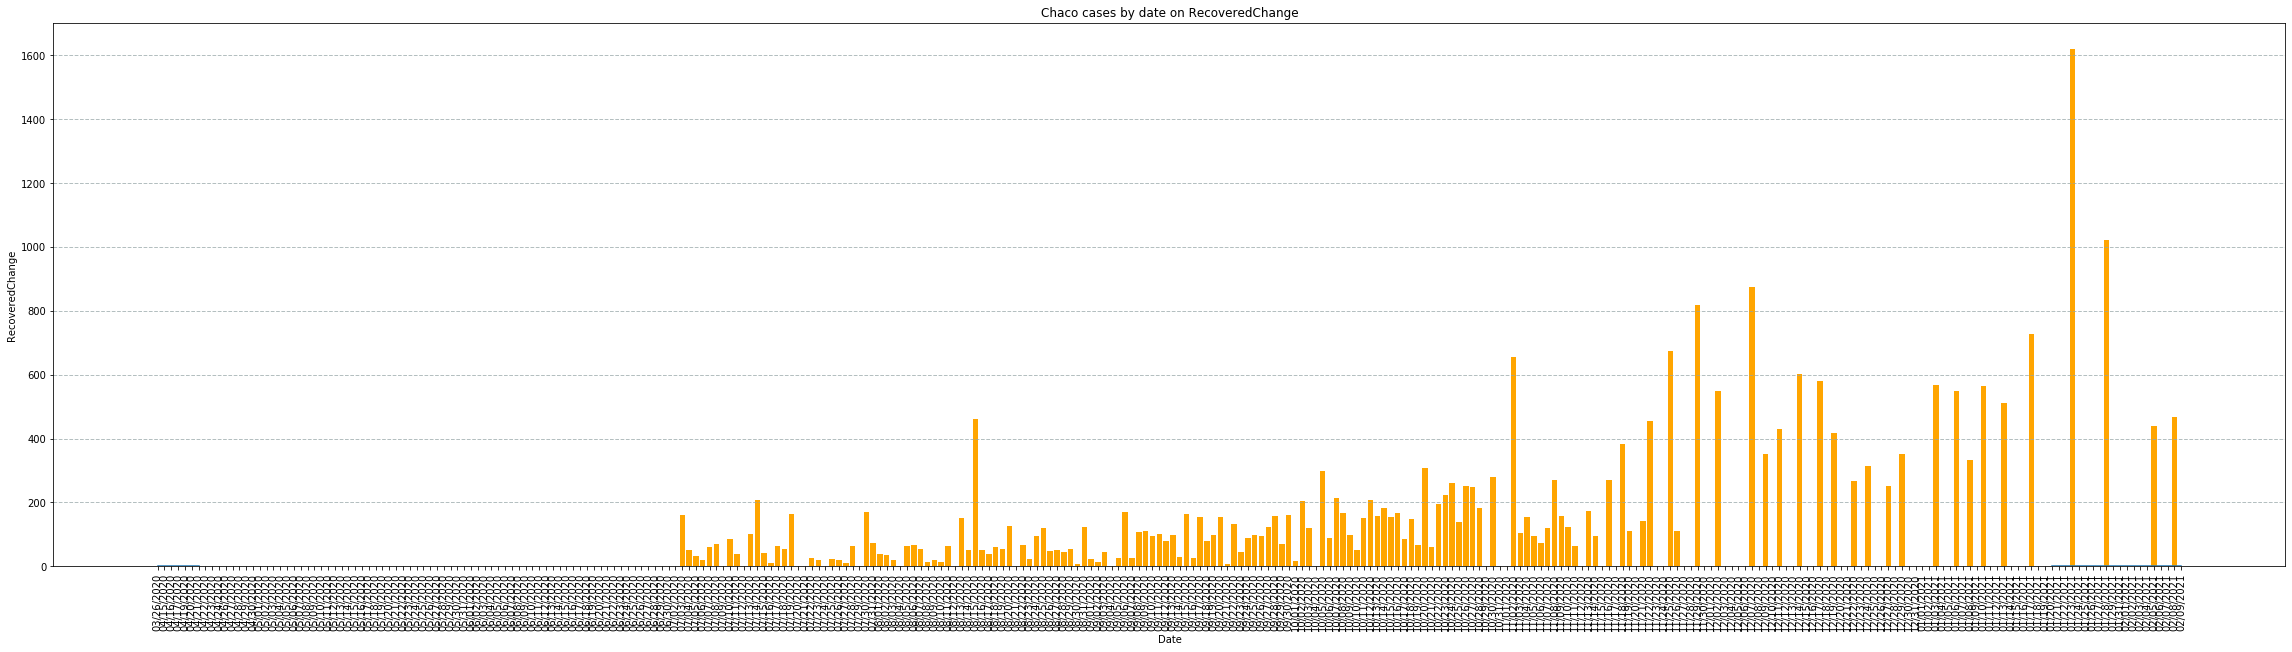

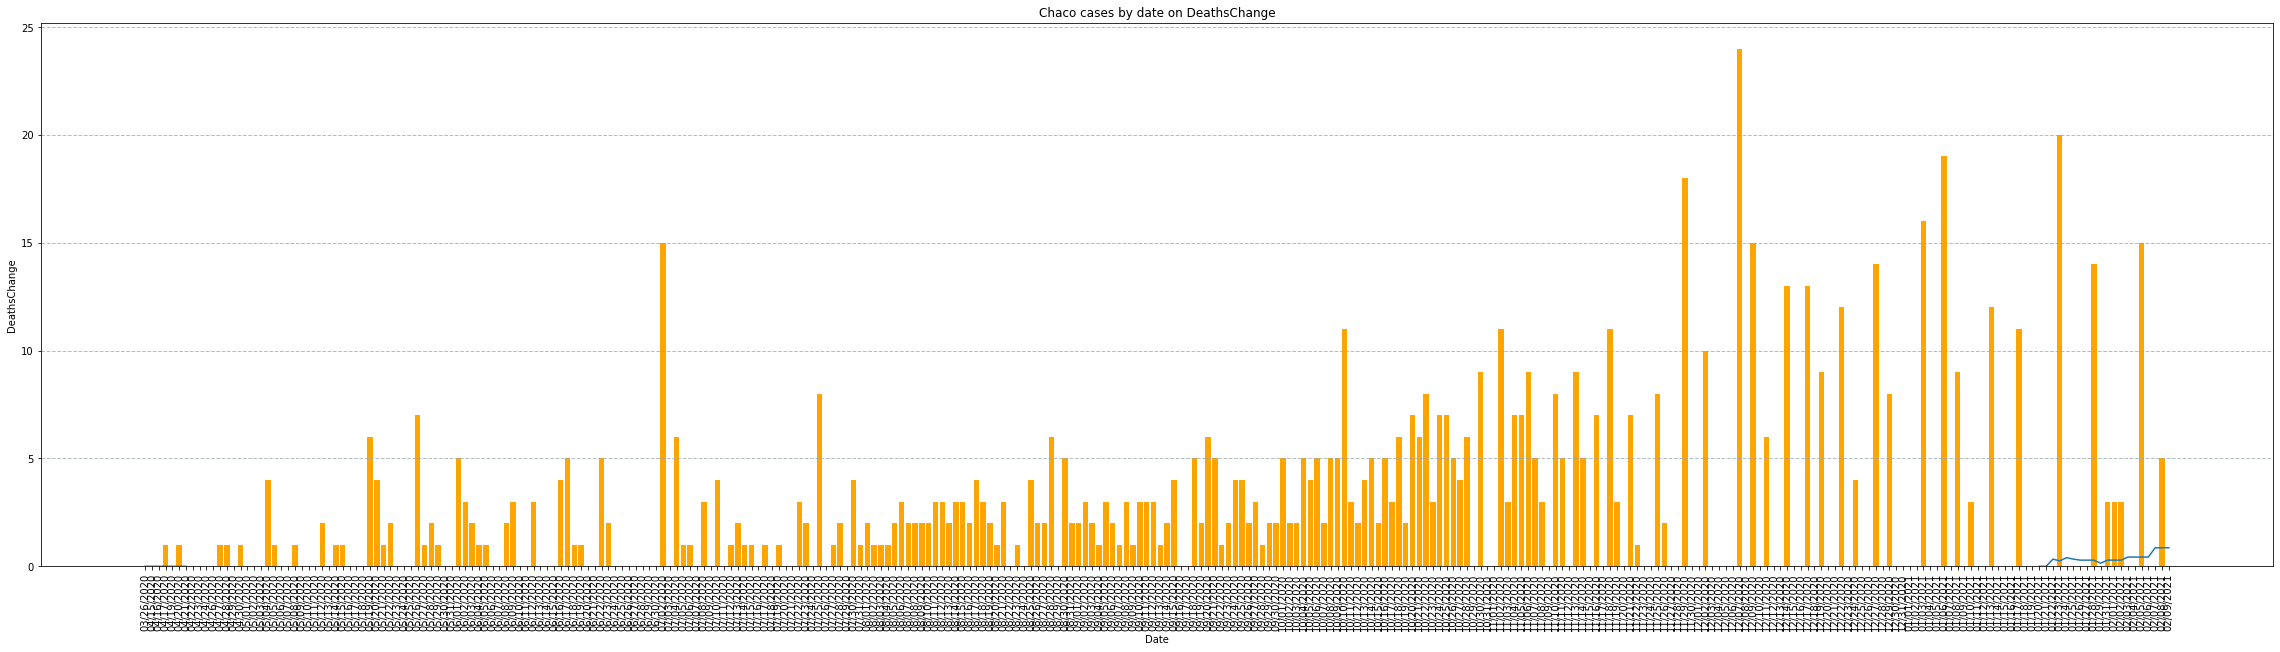

Mean for Confirmed Changed: 105.74832214765101
Features:
[[ 0  0]
 [ 0  0]
 [38  0]
 [11  0]
 [25  0]
 [26  0]
 [ 5  0]
 [ 5  0]
 [ 7  0]
 [10  0]]

Labels:
[0 0 0 1 0 1 0 0 0 0]
Training Set: 536, rows
Test Set: 60 rows
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Predicted labels:  [2. 3. 1. 3. 5. 1. 4. 5. 5. 3.]
Actual labels   :  [3 5 1 7 3 0 9 2 3 3]


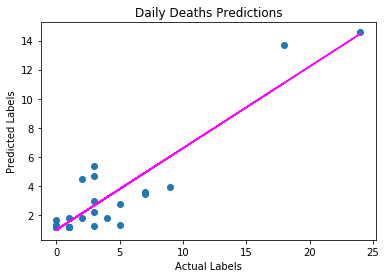

MSE: 7.218884680773182
RMSE: 2.68679822107526
R2: 0.7450258540600501
Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  [0, 1]),
                                                 ('cat',
    

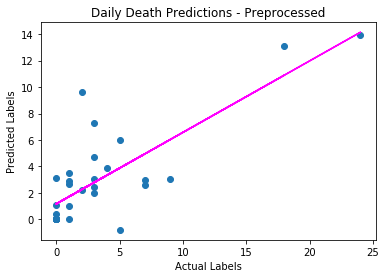

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  [0, 1]),
                                                 ('cat',
                                                  Pipeline(memory=None,
 

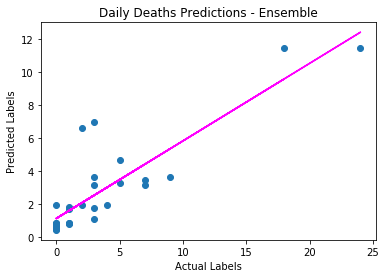

New sample: [148.0, 94.0]
Prediction: 5 deaths


In [10]:
# import pandas as pd
import numpy as np
import pandas as pd
import scipy.stats as stats
import joblib
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

#Store the Argentina data into a pandas' data frame
def readRawData():
    rawDataFrame = pd.read_csv('C:/Users/paulo/Documents/Paulo/Covid19_Data/DataFiles/Bing-covid19_data.csv',delimiter=',',header='infer')
    return rawDataFrame

# Create a bar plot of ConfirmedChange values in state variable by date.
def plot_ConfChange(rawDataFrame, country, column):
    fig, graph  = plt.subplots(figsize=(40, 10))
    graph.bar(x = raw_data.Updated, height = raw_data['{}'.format(column)], color = 'orange')
    graph.plot(raw_data.Updated, raw_data['{}Average'.format(column)], label="{} cases average".format(column))
    # Customize the chart
    plt.title('{} cases by date on {}'.format(country, column))
    plt.xlabel('Date')
    plt.ylabel('{}'.format(column))
    plt.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.7)
    plt.xticks(rotation=90)
    # Display the plot
    plt.show()
    pass

def cleanNaN(raw_data):
    raw_data.Confirmed = raw_data.Confirmed.fillna(0)
    raw_data.ConfirmedChange = raw_data.ConfirmedChange.fillna(0)
    raw_data.Deaths = raw_data.Deaths.fillna(0)
    raw_data.DeathsChange = raw_data.DeathsChange.fillna(0)
    raw_data.Recovered = raw_data.Recovered.fillna(0)
    raw_data.RecoveredChange = raw_data.RecoveredChange.fillna(0)
    raw_data.AdminRegion1 = raw_data.AdminRegion1.fillna('0')
    raw_data.AdminRegion2 = raw_data.AdminRegion2.fillna('0')
    #remove negative values
    raw_data['ConfirmedChange'] = raw_data['ConfirmedChange'].astype(int)
    raw_data.ConfirmedChange = raw_data.ConfirmedChange.mask(raw_data.ConfirmedChange < 0, 0)
    raw_data['DeathsChange'] = raw_data['DeathsChange'].astype(int)
    raw_data.DeathsChange = raw_data.DeathsChange.mask(raw_data.DeathsChange < 0, 0)
    raw_data['RecoveredChange'] = raw_data['RecoveredChange'].astype(int)
    raw_data.RecoveredChange = raw_data.RecoveredChange.mask(raw_data.RecoveredChange < 0, 0)
    raw_data['Confirmed'] = raw_data['Confirmed'].astype(int)
    raw_data['Deaths'] = raw_data['Deaths'].astype(int)
    raw_data['Recovered'] = raw_data['Recovered'].astype(int)
    #remove columns that won't be used
    raw_data = raw_data.drop(['Latitude', 'Longitude', 'ISO2', 'ISO3'], axis=1)
    return raw_data

def query_country(raw_data, country):
    country_data = raw_data[(raw_data['Country_Region'] =="{}".format(country)) & (raw_data['AdminRegion1']=='0')]
    return country_data

def query_state(raw_data, state):
    state_data = raw_data[(raw_data['AdminRegion1'] =="{}".format(state)) & (raw_data['AdminRegion2']=='0')]
    return state_data

def query_similar_states(raw_data, state, state2, state3, state4):
    state_data = raw_data[((raw_data['AdminRegion1'] =="{}".format(state)) & (raw_data['AdminRegion2']=='0')) |
                          ((raw_data['AdminRegion1'] =="{}".format(state2)) & (raw_data['AdminRegion2']=='0')) |
                          ((raw_data['AdminRegion1'] =="{}".format(state3)) & (raw_data['AdminRegion2']=='0')) |
                          ((raw_data['AdminRegion1'] =="{}".format(state4)) & (raw_data['AdminRegion2']=='0'))]
    return state_data

def add_7daysAverage(raw_data, column):
    index = list(raw_data.index.values)#this index is the where the raw_data starts as a reference with rawDataFrame
    sevenDaysMean = [0,0,0,0,0,0]
    for i in range(len(raw_data)-6):
        sevenDaysMean.append(raw_data.loc[index[0]+i:index[0]+6+i,'{}'.format(column)].mean())
    #Add the sevenDaysMean to the dataframe
    raw_data['{}Average'.format(column)] = sevenDaysMean
    return raw_data

#This function is to review the effect of latest numbes of cases against deaths
#Average out 14 days from -3weeks to -2weeks, agaist the deaths average of the last week
def last_3weeks_analysis(raw_data):
    index = list(raw_data.index.values)#this index is the where the raw_data starts as a reference with rawDataFrame
    ConfirmedDaysMean = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    DeathDaysMean = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    for i in range(len(raw_data)-20):
        sevenDaysMean.append(raw_data.loc[index[0]+i:index[0]+14+i,'ConfirmedChange'].mean())
    #Add the sevenDaysMean to the dataframe
    raw_data['{}Average'.format(column)] = sevenDaysMean
    return raw_data

#Function to convert the dataframe content into a csv file.
def df_to_csv(raw_data,state):
    gfg_csv_data = raw_data.to_csv('{}_TEST_File.csv'.format(state), index = True)
    pass

   
#Run the Functions
#Load the raw data into a dataframe
raw_data = readRawData()

#Change cells with NaN to 0
raw_data = cleanNaN(raw_data)
raw_data2 = raw_data
#Query raw data for defined Country
country = 'Argentina'
raw_data = query_country(raw_data, country)

#Add column with 7 days average
raw_data = add_7daysAverage(raw_data, 'ConfirmedChange')
raw_data = add_7daysAverage(raw_data, 'RecoveredChange')
raw_data = add_7daysAverage(raw_data, 'DeathsChange')

#Plot the ConfirmedChange plot of the state variable.
plot_ConfChange(raw_data, country, 'ConfirmedChange')
plot_ConfChange(raw_data, country, 'RecoveredChange')
plot_ConfChange(raw_data, country, 'DeathsChange')

#run functions for sate
state = 'Chaco'
raw_data = raw_data2
raw_data = query_state(raw_data, state)
df_to_csv(raw_data,state)

state2 = 'Jujuy'
state3 = 'Entre Rios'
state4 = 'Salta'
similar_states = query_similar_states(raw_data2, state, state2, state3, state4)

df_to_csv(similar_states, 'similar')

#Add column with 7 days average
raw_data = add_7daysAverage(raw_data, 'ConfirmedChange')
raw_data = add_7daysAverage(raw_data, 'RecoveredChange')
raw_data = add_7daysAverage(raw_data, 'DeathsChange')

#Plot the ConfirmedChange plot of the state variable.
plot_ConfChange(raw_data, state, 'ConfirmedChange')
plot_ConfChange(raw_data, state, 'RecoveredChange')
plot_ConfChange(raw_data, state, 'DeathsChange')

#'Date from {}'.format(date_start)
print('Mean for Confirmed Changed:', raw_data.query('AdminRegion1=="{}"'.format(state)).ConfirmedChange.mean())

#------------------------------------------------------------------

#Separate features and labels
X, y = raw_data[['ConfirmedChange', 'RecoveredChange']].values, raw_data['DeathsChange'].values
print('Features:',X[:10], '\nLabels:', y[:10], sep='\n')

# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)
print ('Training Set: %d, rows\nTest Set: %d rows' % (X_train.size, X_test.size))

# Fit a linear regression model on the training set
model = LinearRegression(normalize=False).fit(X_train, y_train)
print (model)

#Evaluate the train model
predictions = model.predict(X_test)
np.set_printoptions(suppress=True)
print('Predicted labels: ', np.round(predictions)[:10])
print('Actual labels   : ' ,y_test[:10])

#Prediction Graph
%matplotlib inline
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Deaths Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

#Calculate errors
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)


#train the model
# Define preprocessing for numeric columns (scale them)
numeric_features = [0, 1]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode them)
categorical_features = [0, 1]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', LinearRegression(normalize=False))])

# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

#Run tests
predictions = model.predict(X_test)
np.set_printoptions(suppress=True)
print('Predicted labels: ', np.round(predictions)[:10])
print('Actual labels: ' ,y_test[:10])

mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Death Predictions - Preprocessed')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

#different model
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', GradientBoostingRegressor())])
# train a logistic regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

#Run tests
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Deaths Predictions - Ensemble')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()


# Save the model as a pickle file
filename = 'C:/Users/paulo/Documents/Paulo/Covid19_Data/DataFiles/models/{}_deaths_predictions.pkl'.format(country)
joblib.dump(model, filename)

# Load the model from the file
loaded_model = joblib.load(filename)

# Create a numpy array containing a new observation (for example tomorrow's seasonal and weather forecast information)
X_new = np.array([[148,94]]).astype('float64')
print ('New sample: {}'.format(list(X_new[0])))

# Use the model to predict tomorrow's rentals
result = loaded_model.predict(X_new)
print('Prediction: {:.0f} deaths'.format(np.round(result[0])))


In [24]:
# Load the model from the file
loaded_model = joblib.load(filename)

# Create a numpy array containing a new observation (for example tomorrow's seasonal and weather forecast information)
X_new = np.array([[57579,18858]]).astype('float64')
print ('New sample: {}'.format(list(X_new[0])))

# Use the model to predict tomorrow's rentals
result = loaded_model.predict(X_new)
print('Prediction: {:.0f} deaths'.format(np.round(result[0])))

New sample: [57579.0, 18858.0]
Prediction: 20 deaths


In [96]:
#passes  = pd.Series(df_students['Grade'] >= 60)
#df_students = pd.concat([df_students, passes.rename("Pass")], axis=1)

#print(raw_data.loc[0:7])
#i=1
#print(raw_data.loc[0+i:6+i,'ConfirmedChange'])
#print(raw_data.loc[0+i:6+i,'ConfirmedChange'].mean())

print(len(raw_data))
#print(raw_data)
sevenDaysMean = [0,0,0,0,0,0]
for i in range(len(raw_data)-6):
    sevenDaysMean.append(raw_data.loc[0+i:6+i,'ConfirmedChange'].mean())
    #new_data = pd.concat([test_data, sevenDaysMean.rename('average')], axis=1)

print(len(sevenDaysMean))
raw_data['ConfirmedChangeAverage'] = sevenDaysMean
#print(raw_data)

#raw_data = raw_data.drop(['Latitude', 'Longitude', 'ISO2', 'ISO3'], axis=1)

#print(raw_data)
#new_data


284
284


C:\Tools\Anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
print(len(test_data))
print(test_data)
print(test_data['ConfirmedChange'])
sevenDaysMean = [0,0,0,0,0,0]

index = list(test_data.index.values)
print('index::', index[0])
#print('column::', test_data.index.row.get_loc('ConfirmedChange'))

for i in range(len(test_data)-6):
    sevenDaysMean.append(test_data.loc[index[0]+i:index[0]+6+i,'ConfirmedChange'].mean())
    #print(test_data.loc[0+i:6+i,'ConfirmedChange'])

print(len(sevenDaysMean))
test_data['ConfirmedChangeAverage'] = sevenDaysMean
print(test_data)

In [ ]:
index = list(raw_data.index.values)#this index is the where the raw_data starts as a reference with rawDataFrame
ConfirmedDaysMean = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
DeathDaysMean = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in range(len(raw_data)-20):
    sevenDaysMean.append(raw_data.loc[index[0]+i:index[0]+14+i,'ConfirmedChange'].mean())
#Add the sevenDaysMean to the dataframe
raw_data['{}Average'.format(column)] = sevenDaysMean

## Section to compare US data with population in each state

https://medium.com/wagovernor/inslee-announces-healthy-washington-roadmap-to-recovery-229b880a6859

Metrics
A region’s phase will be determined by the Department of Health (DOH) in response to four metric requirements. The final metrics for regions will be calculated on Friday, January 8 and will be effective January 11.

To go forward from Phase 1 to Phase 2, regions must meet all four metrics:
Decreasing trend in two-week rate of COVID-19 cases per 100K population (decrease >10%)
Decreasing trend in two-week rate new COVID-19 hospital admission rates per 100K population (decrease >10%)
ICU occupancy (total — COVID-19 and non-COVID-19) of less than 90%
COVID-19 test positivity rate of <10%

To remain in Phase 2, regions must meet at least 3 metrics:
Decreasing or flat trend in two-week rate of COVID-19 cases per 100K population
Decreasing or flat trend in two-week rate new COVID-19 hospital admission rates per 100K population
ICU occupancy (total — COVID-19 and non-COVID-19) of less than 90%
COVID-19 test positivity rate of <10%.

In [11]:
import pandas as pd

def readRawData():
    rawDataFrame = pd.read_csv('C:/Users/paulo/Documents/Paulo/Covid19_Data/DataFiles/Bing-covid19_data.csv',delimiter=',',header='infer')
    return rawDataFrame

#Query for Counties
def query_county(raw_data, state, county):
    county_data = raw_data[(raw_data['AdminRegion1'] =="{}".format(state)) & (raw_data['AdminRegion2'] =="{}".format(county))]
    return county_data

def add_7daysAverage(raw_data, column):
    index = list(raw_data.index.values)#this index is the where the raw_data starts as a reference with rawDataFrame
    sevenDaysMean = [0,0,0,0,0,0]
    for i in range(len(raw_data)-6):
        sevenDaysMean.append(raw_data.loc[index[0]+i:index[0]+6+i,'{}'.format(column)].mean())
    #Add the sevenDaysMean to the dataframe
    raw_data['{}Average'.format(column)] = sevenDaysMean
    return raw_data

# Create a bar plot of ConfirmedChange values in state variable by date.
def plot_ConfChange(rawDataFrame, country, column):
    fig, graph  = plt.subplots(figsize=(40, 10))
    graph.bar(x = rawDataFrame.Updated, height = rawDataFrame['{}'.format(column)], color = 'orange')
    graph.plot(rawDataFrame.Updated, rawDataFrame['{}Average'.format(column)], label="{} cases average".format(column))
    # Customize the chart
    plt.title('{} cases by date on {}'.format(country, column))
    plt.xlabel('Date')
    plt.ylabel('{}'.format(column))
    plt.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.7)
    plt.xticks(rotation=90)
    # Display the plot
    plt.show()
    pass

#Function to calculate the sum of new cases per 2 weeks period
def twoWeeks_newCases(DF_data, start_index, endindex):
    index = DF_data.index.values #get a list of the indexs from the last 4 weeks of data
    new_cases = DF_data.loc[index[start_index]:index[endindex],'ConfirmedChange'].sum()
    return new_cases

#Washington State population by county
WA_popCounty = pd.DataFrame({'County':["Adams County", "Asotin County", "Benton County", "Chelan County", "Clallam County", "Clark County", "Columbia County", "Cowlitz County", 
                                       "Douglas County", "Ferry County", "Franklin County", "Garfield County", "Grant County", "Grays Harbor County", "Island County", 
                                       "Jefferson County", "King County", "Kitsap County", "Kittitas County", "Klickitat County", "Lewis County", "Lincoln County", "Mason County", 
                                       "Okanogan County", "Pacific County", "Pend Oreille County", "Pierce County", "San Juan County", "Skagit County", "Skamania County", 
                                       "Snohomish County", "Spokane County", "Stevens County", "Thurston County", "Wahkiakum County", "Walla Walla County", "Whatcom County", 
                                       "Whitman County", "Yakima County"],
                             'Population':[19983, 22582, 204390, 77200, 77331, 488241, 3985, 110593, 43429, 7627, 95222, 2225, 97733, 75061, 85141, 32221, 2252782, 271473, 
                                           47935, 22425, 80707, 10939, 66768, 42243, 22471, 13724, 904980, 17582, 129205, 12083, 822083, 522798, 45723, 290536, 4488, 60760, 
                                           229247, 50104, 250873]})

#get the last n items from dataframe
test_data = WA_popCounty.iloc[-14:]
#print(test_data)

#get the population value per county
#df['stock'].values[0]
pop_test = int(WA_popCounty['Population'].values[16])
#print(pop_test, type(pop_test))

#print(WA_popCounty)
#for i in WA_popCounty["County"]:
#    print(i)
#Load the raw data into a dataframe

population = WA_popCounty['County'] == 'King County'
#print(population)
test_data = readRawData()

#Change cells with NaN to 0
test_data = cleanNaN(test_data)

#Add column with 7 days average
#raw_data = add_7daysAverage(test_data, 'ConfirmedChange')
#raw_data = add_7daysAverage(test_data, 'RecoveredChange')
#raw_data = add_7daysAverage(test_data, 'DeathsChange')

raw_data = query_county(test_data, 'Washington', 'King County')
raw_data = add_7daysAverage(raw_data, 'ConfirmedChange')
#plot_ConfChange(raw_data, 'Washington', 'ConfirmedChange')
raw_data_2weeks = raw_data.tail(28)
#sum of cases for 14 days
sum14days = raw_data_2weeks['ConfirmedChange'].sum()
#plot_ConfChange(raw_data_2weeks, 'Washington', 'ConfirmedChange')

print('King county sum last 28 days:', sum14days)

#Calculate sum of new cases in last 14 days divided by population of King county times 100K
two_weeks_rate = (raw_data_2weeks['ConfirmedChange'].sum()/int(WA_popCounty['Population'].values[16])) * 100000
print('King county last 28 weeks rate:', two_weeks_rate)

#Official calculation
#Query data from the Puget Sound region (Snohomish, King, Pierce counties)
#PugetSound_data = test_data[(test_data['AdminRegion1'] == "Washington") & ((test_data['AdminRegion2'] == "Snohomish County") | (test_data['AdminRegion2'] == "King County") | (test_data['AdminRegion2'] == "Pierce County"))]
#print(PugetSound_data)
#print('King county data:\n', PugetSound_data[PugetSound_data['AdminRegion2'] == "King County"])

#Population of Puget Sound region
PugetSound_population = int(WA_popCounty['Population'].values[16] + WA_popCounty['Population'].values[26] + WA_popCounty['Population'].values[30])

#Get data by county and add the new cases
days = 41 #set the days to analyze
temp_data = query_county(test_data, 'Washington', 'King County').tail(days)
PugetSound_cases_prev2weeks = twoWeeks_newCases(temp_data, 0, 13)
PugetSound_cases_recent2weeks = twoWeeks_newCases(temp_data, 14, 27)
#print('King county:\n', temp_data)

temp_data = query_county(test_data, 'Washington', 'Snohomish County').tail(days)
PugetSound_cases_prev2weeks = twoWeeks_newCases(temp_data, 0, 13) + PugetSound_cases_prev2weeks
PugetSound_cases_recent2weeks = twoWeeks_newCases(temp_data, 14, 27) + PugetSound_cases_recent2weeks
#print('Snohomish county:\n', temp_data)

temp_data = query_county(test_data, 'Washington', 'Pierce County').tail(days)
PugetSound_cases_prev2weeks = twoWeeks_newCases(temp_data, 0, 13) + PugetSound_cases_prev2weeks
PugetSound_cases_recent2weeks = twoWeeks_newCases(temp_data, 14, 27) + PugetSound_cases_recent2weeks
#print('Pierce county:\n', temp_data)

#Calculate rate, Formula: sum of cases for 2 weeks / population of county * 100K
PugetSound_rate_prev2weeks = (PugetSound_cases_prev2weeks / PugetSound_population) * 100000
PugetSound_rate_recent2weeks = (PugetSound_cases_recent2weeks / PugetSound_population) * 100000

#Calculate trend, formula: (last 2 weeks rate - the previous 2 weeks rate) / the previous 2 weeks rate * 100
PugetSound_trend = 100 * (PugetSound_rate_recent2weeks - PugetSound_rate_prev2weeks) / PugetSound_rate_prev2weeks
print('Summary:~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Previous2weeks:', temp_data['Updated'].values[0], temp_data['Updated'].values[13])
print('Recent2weeks:', temp_data['Updated'].values[14], temp_data['Updated'].values[27])
print('Previous2weeks rate:', PugetSound_rate_prev2weeks)
print('Recent2weeks rate:', PugetSound_rate_recent2weeks)
print('Puget Sound trend:', PugetSound_trend)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

#select the last 4 weeks from the data
raw_data = query_county(test_data, 'Washington', 'King County') #first query the county data
raw_data_4weeks = raw_data.tail(28) #Only use the last 4 weeks plus 10 days since the last 10 days are not official

#calculate the trend from last 28 days
index = raw_data_4weeks.index.values #get a list of the indexs from the last 4 weeks of data
#Formula: sum of cases for 2 weeks / population of county * 100K
four_weeks_rate = (raw_data_4weeks.loc[index[0]:index[13],'ConfirmedChange'].sum()/int(WA_popCounty['Population'].values[16])) * 100000
two_weeks_rate = (raw_data_4weeks.loc[index[14]:index[27],'ConfirmedChange'].sum()/int(WA_popCounty['Population'].values[16])) * 100000

print('King county cases previous 2 weeks:', raw_data_4weeks.loc[index[0]:index[13],'ConfirmedChange'].sum())
print('King county cases recent 2 weeks:',raw_data_4weeks.loc[index[14]:index[27],'ConfirmedChange'].sum())

print('King county rate previous 2 weeks:', four_weeks_rate)
print('King county rate recent 2 weeks:', two_weeks_rate)


#formula: (last 2 weeks rate - the previous 2 weeks rate) / the previous 2 weeks rate * 100
trend = 100 * (two_weeks_rate - four_weeks_rate)/four_weeks_rate
print('King county trend:',trend)
'''
for i in WA_popCounty["County"]:
    #print(query_county(test_data, 'Washington', i))
    #Plot the ConfirmedChange plot of the state variable.
    raw_data = query_county(test_data, 'Washington', i)
    raw_data = add_7daysAverage(raw_data, 'ConfirmedChange')
    #plot_ConfChange(raw_data, i, 'ConfirmedChange')
'''
#plot_ConfChange(raw_data, state, 'RecoveredChange')
#plot_ConfChange(raw_data, state, 'DeathsChange')

C:\Tools\Anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


King county sum last 28 days: 10049
King county last 28 weeks rate: 446.0706806073557
Summary:~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Previous2weeks: 01/01/2021 01/14/2021
Recent2weeks: 01/15/2021 01/28/2021
Previous2weeks rate: 441.49960614044016
Recent2weeks rate: 263.45247113895135
Puget Sound trend: -40.32781287348473
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
King county cases previous 2 weeks: 5601
King county cases recent 2 weeks: 4448
King county rate previous 2 weeks: 248.62592119432773
King county rate recent 2 weeks: 197.444759413028
King county trend: -20.58560971255132


'\nfor i in WA_popCounty["County"]:\n    #print(query_county(test_data, \'Washington\', i))\n    #Plot the ConfirmedChange plot of the state variable.\n    raw_data = query_county(test_data, \'Washington\', i)\n    raw_data = add_7daysAverage(raw_data, \'ConfirmedChange\')\n    #plot_ConfChange(raw_data, i, \'ConfirmedChange\')\n'

In [12]:
#Code to sort US states by new cases increses by the last 2 weeks in relation to its population.
#Code to sort US states by deaths percentages by the last 2 weeks death cases and the previous 2 weeks of new infections.

def readRawData():
    rawDataFrame = pd.read_csv('C:/Users/paulo/Documents/Paulo/Covid19_Data/DataFiles/Bing-covid19_data.csv',delimiter=',',header='infer')
    return rawDataFrame

#Function to query the data of a US state
def query_state(raw_data, state):
    state_data = raw_data[(raw_data['AdminRegion1']=='{}'.format(state)) & (raw_data['AdminRegion2'] == '0')]
    return state_data

#Function to calculate the sum of new cases per 2 weeks period
def twoWeeks_newCases(DF_data, start_index, endindex):
    index = DF_data.index.values #get a list of the indexs from the last 4 weeks of data
    new_cases = DF_data.loc[index[start_index]:index[endindex],'ConfirmedChange'].sum()
    return new_cases

#Function to calculate the sum of new deaths per 2 weeks period
def twoWeeks_newDeaths(DF_data, start_index, endindex):
    index = DF_data.index.values #get a list of the indexs from the last 4 weeks of data
    new_deaths = DF_data.loc[index[start_index]:index[endindex],'DeathsChange'].sum()
    return new_deaths
    
    
usa_popState = pd.DataFrame({'State':['California', 'Texas', 'Florida', 'New York', 'Pennsylvania', 'Illinois', 'Ohio', 'Georgia', 'North Carolina', 'Michigan', 'New Jersey', 
                                       'Virginia', 'Washington', 'Arizona', 'Massachusetts', 'Tennessee', 'Indiana', 'Missouri', 'Maryland', 'Wisconsin', 'Colorado', 'Minnesota', 
                                       'South Carolina', 'Alabama', 'Louisiana', 'Kentucky', 'Oregon', 'Oklahoma', 'Connecticut', 'Utah', 'Iowa', 'Nevada','Arkansas', 
                                       'Mississippi', 'Kansas', 'New Mexico', 'Nebraska', 'West Virginia', 'Idaho', 'Hawaii', 'New Hampshire', 'Maine', 'Montana', 'Rhode Island', 
                                       'Delaware', 'South Dakota', 'North Dakota', 'Alaska', 'District of Columbia', 'Vermont', 'Wyoming'],
                             'Population':[39512223,28995881,21477737,19453561,12801989,12671821,11689100,10617423,10488084,9986857,8882190,8535519,7614893,7278717,6892503,6829174,
                                            6732219,6137428,6045680,5822434,5758736,5639632,5148714,4903185,4648794,4467673,4217737,3956971,3565287,3205958,3155070,3080156,
                                            3017804,2976149,2913314,2096829,1934408,1792147,1787065,1415872,1359711,1344212,1068778,1059361,973764,884659,762062,731545,705749,623989,
                                            578759]})

#Load the raw data into a dataframe
test_data = readRawData()

#Change cells with NaN to 0
test_data = cleanNaN(test_data)

confirmed_percentage = []
confirmed_cases_list = []
death_percentage = []
death_cases_list = []
days = 28
for i in range(len(usa_popState)):
    #Get the state info by date and state
    state_data = query_state(test_data, usa_popState.loc[i,'State']).tail(days)
    temp_cases = twoWeeks_newCases(state_data, 14, 27) #Get the sum of confirmed cases by state 
    temp_deaths = twoWeeks_newDeaths(state_data, 14, 27) #Get the sum of deaths by state
    temp_cases_4weeks = twoWeeks_newCases(state_data, 0, 13) #Get cases from 4 weeks back to calculate death rates
    confirmed_cases_list.append(temp_cases) #store sum of new cases in a list
    death_cases_list.append(temp_deaths) #store sum of new deaths in a list
    #state infection percentage
    temp_percentage = 100*(temp_cases/usa_popState.loc[i,'Population'])
    confirmed_percentage.append(temp_percentage)
    #state deaths percentage
    temp_percentage = 100*(temp_deaths/temp_cases_4weeks)#calculate using confirmed cases instead of population: usa_popState.loc[i,'Population'])
    death_percentage.append(temp_percentage)
    pass

usa_popState['StateInfectionPerc'] = confirmed_percentage
usa_popState['ConfirmedCases'] = confirmed_cases_list
usa_popState['DeathPerc'] = death_percentage
usa_popState['DeathCases'] = death_cases_list

#sorted by percentage
usa_popState = usa_popState.sort_values('StateInfectionPerc', ascending=False, ignore_index=True)


print('sorted by Infections percentage in the last {} days:'.format(days))
usa_popState

sorted by Infections percentage in the last 28 days:


,State,Population,StateInfectionPerc,ConfirmedCases,DeathPerc,DeathCases
0,South Carolina,5148714,0.905935,46644,1.733789,1115
1,Texas,28995881,0.775010,224721,1.561661,4218
2,Oklahoma,3956971,0.749058,29640,1.403752,547
3,Arkansas,3017804,0.717774,21661,1.657379,458
4,North Carolina,10488084,0.711684,74642,1.388767,1270
5,Arizona,7278717,0.696332,50684,1.878472,1819
6,Kentucky,4467673,0.684764,30593,1.509605,631
7,New York,19453561,0.647717,126004,0.995108,1902
8,Rhode Island,1059361,0.606498,6425,1.085286,113
9,Virginia,8535519,0.595043,50790,0.960480,724


In [13]:
print('sorted by Death percentage in the last {} days:'.format(days))
usa_popState = usa_popState.sort_values('DeathPerc', ascending=False, ignore_index=True)
usa_popState

sorted by Death percentage in the last 28 days:


,State,Population,StateInfectionPerc,ConfirmedCases,DeathPerc,DeathCases
0,Indiana,6732219,0.367932,24770,4.718120,2032
1,Alabama,4903185,0.550275,26981,4.505001,1716
2,Iowa,3155070,0.348392,10992,4.000000,653
3,Tennessee,6829174,0.513327,35056,2.850656,1469
4,Kansas,2913314,0.345311,10060,2.615658,575
5,Montana,1068778,0.380247,4064,2.439524,119
6,Nevada,3080156,0.387058,11922,2.252615,448
7,South Dakota,884659,0.222911,1972,2.226780,76
8,New Mexico,2096829,0.369272,7743,2.204896,263
9,Pennsylvania,12801989,0.503187,64418,2.196899,1737


In [14]:
#this calculation is using the total cases since pandemic started.
def readRawData():
    rawDataFrame = pd.read_csv('C:/Users/paulo/Documents/Paulo/Covid19_Data/DataFiles/Bing-covid19_data.csv',delimiter=',',header='infer')
    return rawDataFrame

#US population by state

usa_popState = pd.DataFrame({'State':['California', 'Texas', 'Florida', 'New York', 'Pennsylvania', 'Illinois', 'Ohio', 'Georgia', 'North Carolina', 'Michigan', 'New Jersey', 
                                       'Virginia', 'Washington', 'Arizona', 'Massachusetts', 'Tennessee', 'Indiana', 'Missouri', 'Maryland', 'Wisconsin', 'Colorado', 'Minnesota', 
                                       'South Carolina', 'Alabama', 'Louisiana', 'Kentucky', 'Oregon', 'Oklahoma', 'Connecticut', 'Utah', 'Iowa', 'Nevada','Arkansas', 
                                       'Mississippi', 'Kansas', 'New Mexico', 'Nebraska', 'West Virginia', 'Idaho', 'Hawaii', 'New Hampshire', 'Maine', 'Montana', 'Rhode Island', 
                                       'Delaware', 'South Dakota', 'North Dakota', 'Alaska', 'District of Columbia', 'Vermont', 'Wyoming'],
                             'Population':[39512223,28995881,21477737,19453561,12801989,12671821,11689100,10617423,10488084,9986857,8882190,8535519,7614893,7278717,6892503,6829174,
                                            6732219,6137428,6045680,5822434,5758736,5639632,5148714,4903185,4648794,4467673,4217737,3956971,3565287,3205958,3155070,3080156,
                                            3017804,2976149,2913314,2096829,1934408,1792147,1787065,1415872,1359711,1344212,1068778,1059361,973764,884659,762062,731545,705749,623989,
                                            578759]})
'''
usa_popState = pd.DataFrame({'State':['California', 'Texas', 'Florida', 'New York', 'Pennsylvania', 'Illinois', 'Ohio', 'Georgia', 'North Carolina', 'Michigan', 'New Jersey', 
                                       'Virginia', 'Washington', 'Arizona', 'Massachusetts', 'Tennessee', 'Indiana', 'Missouri', 'Maryland', 'Wisconsin', 'Colorado', 'Minnesota', 
                                       'South Carolina', 'Alabama', 'Louisiana', 'Kentucky', 'Oregon', 'Oklahoma', 'Connecticut', 'Utah', 'Iowa', 'Nevada','Arkansas', 
                                       'Mississippi', 'Kansas', 'New Mexico', 'Nebraska', 'West Virginia', 'Idaho', 'New Hampshire', 'Maine', 'Montana', 'Rhode Island', 
                                       'Delaware', 'South Dakota', 'North Dakota', 'Alaska', 'District of Columbia', 'Vermont', 'Wyoming'],
                             'Population':[39512223,28995881,21477737,19453561,12801989,12671821,11689100,10617423,10488084,9986857,8882190,8535519,7614893,7278717,6892503,6829174,
                                            6732219,6137428,6045680,5822434,5758736,5639632,5148714,4903185,4648794,4467673,4217737,3956971,3565287,3205958,3155070,3080156,
                                            3017804,2976149,2913314,2096829,1934408,1792147,1787065,1359711,1344212,1068778,1059361,973764,884659,762062,731545,705749,623989,
                                            578759]})
'''

#make all population int()
usa_popState['Population'] = usa_popState['Population'].astype(int)

####temporatly drop Hawaii becasue it is missing latest data
#index = usa_popState[usa_popState['State'] == 'Hawaii'].index
#print(index)
#usa_popState.drop(index, inplace=True)
#print(usa_popState)

#Load the raw data into a dataframe
test_data = readRawData()

#Change cells with NaN to 0
test_data = cleanNaN(test_data)

date = test_data['Updated'].values[-1]
#date = '12/14/2020'
print('Report from:', date)

#for i in usa_popState['State']:
#    if i not in test_data['AdminRegion1']:
#        print(i)

confirmed_percentage = []
confirmed_cases_list = []
death_percentage = []
death_cases_list = []
for i in range(len(usa_popState)):
    #Get the state info by date and state
    state_data = test_data[(test_data['Updated'] =="{}".format(date)) & (test_data['AdminRegion1']=='{}'.format(usa_popState.loc[i,'State'])) & (test_data['AdminRegion2'] == '0')]
    
    #Get the confirmed cases by state and change it int()   
    confirmed_cases = int(state_data['Confirmed'].astype(int))
    confirmed_cases_list.append(confirmed_cases)
    #state infection percentage
    percentage = 100*(confirmed_cases/usa_popState.loc[i,'Population'])
    confirmed_percentage.append(percentage)
    #Get the death cases by state and change it int()   
    death_cases = int(state_data['Deaths'].astype(int))
    death_cases_list.append(death_cases)
    #state deaths percentage
    percentage = 100*(death_cases/confirmed_cases)#calculate using confirmed cases instead of population: usa_popState.loc[i,'Population'])
    death_percentage.append(percentage)
    pass

usa_popState['StateInfectionPerc'] = confirmed_percentage
usa_popState['ConfirmedCases'] = confirmed_cases_list
usa_popState['DeathPerc'] = death_percentage
usa_popState['DeathCases'] = death_cases_list

#sorted by percentage
usa_popState = usa_popState.sort_values('StateInfectionPerc', ascending=False, ignore_index=True)


print('sorted by Infections percentage:')
usa_popState

Report from: 02/09/2021
sorted by Infections percentage:


,State,Population,StateInfectionPerc,ConfirmedCases,DeathPerc,DeathCases
0,North Dakota,762062,12.887928,98214,1.454986,1429
1,South Dakota,884659,12.366912,109405,1.653489,1809
2,Rhode Island,1059361,11.274155,119434,1.882211,2248
3,Utah,3205958,11.146091,357339,0.493929,1765
4,Tennessee,6829174,10.945130,747462,1.422280,10631
5,Arizona,7278717,10.816027,787268,1.814630,14286
6,Iowa,3155070,10.312988,325382,1.581218,5145
7,Oklahoma,3956971,10.261991,406064,0.953052,3870
8,Arkansas,3017804,10.234197,308848,1.666839,5148
9,Nebraska,1934408,10.037696,194170,1.018695,1978


In [15]:
print('Report from:', date)
print('sorted by Death percentage:')
usa_popState = usa_popState.sort_values('DeathPerc', ascending=False, ignore_index=True)
usa_popState

Report from: 02/09/2021
sorted by Death percentage:


,State,Population,StateInfectionPerc,ConfirmedCases,DeathPerc,DeathCases
0,Massachusetts,6892503,7.934650,546896,2.765425,15124
1,Connecticut,3565287,7.421787,264608,2.758042,7298
2,New Jersey,8882190,8.187688,727246,2.738551,19916
3,Michigan,9986857,5.707301,569980,2.625531,14965
4,Pennsylvania,12801989,6.849818,876913,2.579503,22620
5,District of Columbia,705749,5.243791,37008,2.475141,916
6,New York,19453561,7.644287,1487086,2.453187,36481
7,Mississippi,2976149,9.507891,282969,2.241235,6342
8,Louisiana,4648794,8.913150,414354,2.211153,9162
9,Maryland,6045680,6.046119,365529,1.979050,7234


In [ ]:
# Separate features and labels
X, y = ArgRawData[['ConfirmedChange', 'RecoveredChange']].values, ArgRawData['DeathsChange'].values
print('Features:',X[:10], '\nLabels:', y[:10], sep='\n')

#numeric_features = ['Confirmed','ConfirmedChange', 'Deaths', 'DeathsChange', 'Recovered', 'RecoveredChange']

In [ ]:
from sklearn.model_selection import train_test_split

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)

print ('Training Set: %d, rows\nTest Set: %d rows' % (X_train.size, X_test.size))

In [ ]:
# Train the model
from sklearn.linear_model import LinearRegression

# Fit a linear regression model on the training set
model = LinearRegression(normalize=False).fit(X_train, y_train)
print (model)

In [ ]:
#Evaluate the train model

import numpy as np

predictions = model.predict(X_test)
np.set_printoptions(suppress=True)
print('Predicted labels: ', np.round(predictions)[:10])
print('Actual labels   : ' ,y_test[:10])

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Deaths Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

You can quantify the residuals by calculating a number of commonly used evaluation metrics. We'll focus on the following three:

- **Mean Square Error (MSE)**: The mean difference between predicted and actual, squared. This yields a relative metric in which the smaller the value, the better the fit of the model
- **Root Mean Square Error (RMSE)**: The square root of the MSE. This yields an absolute metric in the same unit as the label (in this case, numbers of deaths). The smaller the value, the better the model (in a simplistic sense, it represents the average number of deaths by which the predictions are wrong!)
- **Coefficient of Determination (usually known as *R-squared* or R<sup>2</sup>**: A relative metric in which the higher the value, the better the fit of the model. In essence, this metric represents how much of the variance between predicted and actual label values the model is able to explain.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, predictions)
print("R2:", r2)

In [ ]:
# Train the model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
import numpy as np

# Define preprocessing for numeric columns (scale them)
numeric_features = [0, 1]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode them)
categorical_features = [0, 1]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', LinearRegression(normalize=False))])


# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

In [ ]:
predictions = model.predict(X_test)
np.set_printoptions(suppress=True)
print('Predicted labels: ', np.round(predictions)[:10])
print('Actual labels: ' ,y_test[:10])

mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Death Predictions - Preprocessed')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

### Try a Different Algorithm

The linear regression algorithm we used to train the model has some predictive capability, but there are many kinds of regression algorithm we could try, including:

- **Linear algorithms**: Not just the Linear Regression algorithm we used above (which is technically an *Ordinary Least Squares* algorithm), but other variants such as *Lasso* and *Ridge*.
- **Tree-based algorithms**: Algorithms that build a decision tree to reach a prediction
- **Ensemble algorithms**: Algorithms that combine the outputs of multiple base algorithms to improve generalizability.

Let's try training our regression model by using an ensemble algorithm called **Gradient Boosting**. We can do this by just changing the last step of the pipeline.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', GradientBoostingRegressor())])


# train a logistic regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

In [ ]:
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Deaths Predictions - Ensemble')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

In [ ]:
#Use the trained model
import joblib

# Save the model as a pickle file
#filename = 'C:/Users/paulo/Documents/Paulo/Covid19_Data/DataFiles/models/Arg_deaths_predictions_fromprovincesdata.pkl'
filename = 'C:/Users/paulo/Documents/Paulo/Covid19_Data/DataFiles/models/Arg_deaths_predictions.pkl'
joblib.dump(model, filename)

In [ ]:
# Load the model from the file
loaded_model = joblib.load(filename)

# Create a numpy array containing a new observation (for example tomorrow's seasonal and weather forecast information)
X_new = np.array([[17096,0]]).astype('float64')
print ('New sample: {}'.format(list(X_new[0])))

# Use the model to predict tomorrow's rentals
result = loaded_model.predict(X_new)
print('Prediction: {:.0f} deaths'.format(np.round(result[0])))

## Load Washington data and calculate 
https://medium.com/wagovernor/inslee-announces-healthy-washington-roadmap-to-recovery-229b880a6859

File: https://www.doh.wa.gov/Portals/1/Documents/1600/coronavirus/data-tables/WA_COVID19_Cases_Hospitalizations_Deaths.xlsx?ver=20210126082052

Metrics
A region’s phase will be determined by the Department of Health (DOH) in response to four metric requirements. The final metrics for regions will be calculated on Friday, January 8 and will be effective January 11.

To go forward from Phase 1 to Phase 2, regions must meet all four metrics:
Decreasing trend in two-week rate of COVID-19 cases per 100K population (decrease >10%)
Decreasing trend in two-week rate new COVID-19 hospital admission rates per 100K population (decrease >10%)
ICU occupancy (total — COVID-19 and non-COVID-19) of less than 90%
COVID-19 test positivity rate of <10%

To remain in Phase 2, regions must meet at least 3 metrics:
Decreasing or flat trend in two-week rate of COVID-19 cases per 100K population
Decreasing or flat trend in two-week rate new COVID-19 hospital admission rates per 100K population
ICU occupancy (total — COVID-19 and non-COVID-19) of less than 90%
COVID-19 test positivity rate of <10%.

In [16]:
import pandas as pd

#Query for Counties
def query_WA_county(raw_data, county):
    county_data = raw_data[(raw_data['County'] =="{}".format(county))]
    return county_data


#Function to calculate the sum of new cases per 2 weeks period. Column variable is the column name used to sum the data.
def twoWeeks_newCases(DF_data, column, start_index, endindex):
    index = DF_data.index.values #get a list of the indexs from the last 4 weeks of data
    new_cases = DF_data.loc[index[start_index]:index[endindex],'{}'.format(column)].sum()
    return new_cases

#Drop a row with invalid data in the dataframe
def drop_row(DF_data, column, value):
    index = DF_data[DF_data[column] == value].index #find the index value of the row I want to remove
    DF_data.drop(index, inplace=True)
    return DF_data


df_cases = pd.read_excel('C:/Users/paulo/Documents/Paulo/Covid19_Data/WA_COVID19_Cases_Hospitalizations_Deaths.xlsx', sheet_name='Cases')
df_hospitalizations = pd.read_excel('C:/Users/paulo/Documents/Paulo/Covid19_Data/WA_COVID19_Cases_Hospitalizations_Deaths.xlsx', sheet_name='Hospitalizations')
df_deaths = pd.read_excel('C:/Users/paulo/Documents/Paulo/Covid19_Data/WA_COVID19_Cases_Hospitalizations_Deaths.xlsx', sheet_name='Deaths')

df_cases = drop_row(df_cases, 'WeekStartDate', 'Unknown')
df_hospitalizations = drop_row(df_hospitalizations, 'WeekStartDate', 'Unknown')
df_deaths = drop_row(df_deaths, 'WeekStartDate', 'Unknown')

#Official calculation
#Query data from the Puget Sound region (Snohomish, King, Pierce counties)
#PugetSound_data = test_data[(test_data['AdminRegion1'] == "Washington") & ((test_data['AdminRegion2'] == "Snohomish County") | (test_data['AdminRegion2'] == "King County") | (test_data['AdminRegion2'] == "Pierce County"))]
#print(PugetSound_data)
#print('King county data:\n', PugetSound_data[PugetSound_data['AdminRegion2'] == "King County"])


#Population of Puget Sound region
PugetSound_population = int(WA_popCounty['Population'].values[16] + WA_popCounty['Population'].values[26] + WA_popCounty['Population'].values[30])

#Get data by county and add the new cases
weeks = 4 #set the days to analyze
temp_data = query_WA_county(df_cases, 'King County').tail(weeks)
PugetSound_cases_prev2weeks = twoWeeks_newCases(temp_data, 'TotalCases', 0, 1)
PugetSound_cases_recent2weeks = twoWeeks_newCases(temp_data, 'TotalCases', 2, 3)
#Hospitalizations
temp_data = query_WA_county(df_hospitalizations, 'King County').tail(weeks)
PugetSound_hospitalizations_prev2weeks = twoWeeks_newCases(temp_data, 'Hospitalizations', 0, 1)
PugetSound_hospitalizations_recent2weeks = twoWeeks_newCases(temp_data, 'Hospitalizations', 2, 3)

temp_data = query_WA_county(df_cases, 'Snohomish County').tail(weeks)
PugetSound_cases_prev2weeks = twoWeeks_newCases(temp_data, 'TotalCases', 0, 1) + PugetSound_cases_prev2weeks
PugetSound_cases_recent2weeks = twoWeeks_newCases(temp_data, 'TotalCases', 2, 3) + PugetSound_cases_recent2weeks
#Hospitalizations
temp_data = query_WA_county(df_hospitalizations, 'Snohomish County').tail(weeks)
PugetSound_hospitalizations_prev2weeks = twoWeeks_newCases(temp_data, 'Hospitalizations', 0, 1)
PugetSound_hospitalizations_recent2weeks = twoWeeks_newCases(temp_data, 'Hospitalizations', 2, 3)

temp_data = query_WA_county(df_cases, 'Pierce County').tail(weeks)
PugetSound_cases_prev2weeks = twoWeeks_newCases(temp_data, 'TotalCases', 0, 1) + PugetSound_cases_prev2weeks
PugetSound_cases_recent2weeks = twoWeeks_newCases(temp_data, 'TotalCases', 2, 3) + PugetSound_cases_recent2weeks
#Hospitalizations
temp_data = query_WA_county(df_hospitalizations, 'Pierce County').tail(weeks)
PugetSound_hospitalizations_prev2weeks = twoWeeks_newCases(temp_data, 'Hospitalizations', 0, 1)
PugetSound_hospitalizations_recent2weeks = twoWeeks_newCases(temp_data, 'Hospitalizations', 2, 3)

#Calculate rate, Formula: sum of cases for 2 weeks / population of county * 100K
PugetSound_rate_prev2weeks = (PugetSound_cases_prev2weeks / PugetSound_population) * 100000
PugetSound_rate_recent2weeks = (PugetSound_cases_recent2weeks / PugetSound_population) * 100000

#Calculate rate for hospitalizations
PugetSound_rateHosp_prev2weeks = (PugetSound_hospitalizations_prev2weeks / PugetSound_population) * 100000
PugetSound_rateHosp_recent2weeks = (PugetSound_hospitalizations_recent2weeks / PugetSound_population) * 100000

#Calculate trend, formula: (last 2 weeks rate - the previous 2 weeks rate) / the previous 2 weeks rate * 100
PugetSound_trend = 100 * (PugetSound_rate_recent2weeks - PugetSound_rate_prev2weeks) / PugetSound_rate_prev2weeks

#Calculate trend for hospitalizations
PugetSound_trendHosp = 100 * (PugetSound_rateHosp_recent2weeks - PugetSound_rateHosp_prev2weeks) / PugetSound_rateHosp_prev2weeks
print('Summary:~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Previous2weeks:', temp_data['WeekStartDate'].values[0], temp_data['WeekStartDate'].values[1])
print('Recent2weeks:', temp_data['WeekStartDate'].values[2], temp_data['WeekStartDate'].values[3])
print('Previous2weeks rate:', PugetSound_rate_prev2weeks)
print('Recent2weeks rate:', PugetSound_rate_recent2weeks)
print('Puget Sound trend:', PugetSound_trend)
print('Previous2weeks Hospitalizations rate:', PugetSound_rateHosp_prev2weeks)
print('Recent2weeks Hospitalizations rate:', PugetSound_rateHosp_recent2weeks)
print('Puget Sound Hospitalizations trend:', PugetSound_trendHosp)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

Summary:~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Previous2weeks: 2021-01-10 2021-01-17
Recent2weeks: 2021-01-24 2021-01-31
Previous2weeks rate: 224.7072436238095
Recent2weeks rate: 105.55687470240676
Puget Sound trend: -53.024712065302474
Previous2weeks Hospitalizations rate: 5.477600258301517
Recent2weeks Hospitalizations rate: 4.4474093840338
Puget Sound Hospitalizations trend: -18.807339449541296
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
